In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
import sqlite3
from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [3]:
import re

In [66]:
ls

In [127]:
# Abstract has been in place since 2005

# Loading the Data and EDA

## Data Pipeline to Save CSV:

In [68]:
#connect to databse
conn = sqlite3.connect("../pitchfork-data/pitchfork_2017.db")
#create dataframes for each table
df = pd.read_sql_query("select * from reviews;", conn)
df_reviews = pd.read_sql_query("select * from content", conn)
df_years = pd.read_sql_query("select * from years;", conn)
df_genres = pd.read_sql_query("select * from genres", conn)
#create dummies to allow for multiple genres for each review
df_genres = pd.get_dummies(df_genres, columns=['genre']).groupby('reviewid').sum().reset_index()


In [69]:
#merge tables
df = df.merge(df_years)
df = df.merge(df_genres)
df = df.merge(df_reviews).reset_index()


df.year.fillna(value=df.pub_year, inplace=True)
df.drop_duplicates('reviewid',inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.drop('author_type', axis=1, inplace=True)
df.year = df.year.astype(int)
df = df[df['pub_year'] < 2018]

# Feature Engineering

In [70]:
#Reviews containing the following words are reissued albums
list_of_words = ['reissue', 'remaster', 'box set', 'collector', 'delux']

def parse_content_for_reissue(df, list_of_words):
    df['reissue'] = 0
    for each in list_of_words:
        df['reissue'] = df['reissue'] + df['abstract'].str.contains(each).astype('int')
    df['reissue'] = df['reissue'] + df['best_new_reissue'].astype('int')
    df['reissue'] = df['reissue'].astype(bool).astype(int)

parse_content_for_reissue(df, list_of_words)

In [71]:
#Reviews that were reviewed years after their release are classic albums
df['num_years_since_release'] = df.pub_year - df.year

df['new_album'] = ((df['reissue'] == 0) & (df['num_years_since_release'] <= 1)).astype(int)

In [72]:
df.reset_index(inplace=True)

In [73]:
def f(string):
    return re.sub('[^A-Za-z0-9]+', ' ', string)

df['content_stripped'] = df['content'].map(f)

In [74]:
#Adding Sentiment Scores with TextBlob. This will come in handy later.

sentiments = []
for each in range(len(df['reviewid'])):
    sentiments.append((df['reviewid'].iloc[each], TextBlob(df['content_stripped'][each]).sentiment[0], TextBlob(df['content_stripped'][each]).sentiment[1]))
#                           TextBlob(df_mid['content'][each], analyzer=NaiveBayesAnalyzer()).sentiment))

df_cont_sent = pd.DataFrame(sentiments, columns=['reviewid', 'cont_polarity', 'cont_subjectivity'])

In [75]:
#Adding Sentiment Scores with TextBlob. This will come in handy later.

sentiments = []
for each in range(len(df['reviewid'])):
    sentiments.append((df['reviewid'].iloc[each], TextBlob(df['abstract'][each]).sentiment[0], TextBlob(df['abstract'][each]).sentiment[1]))
#                           TextBlob(df_mid['content'][each], analyzer=NaiveBayesAnalyzer()).sentiment))

df_abs_sent = pd.DataFrame(sentiments, columns=['reviewid', 'abs_polarity', 'abs_subjectivity'])

In [76]:
df = df.merge(df_abs_sent)
df = df.merge(df_cont_sent)

In [10]:
df['score_bin'] = (df['score'] // 1).astype(int)

In [77]:
# save CSV one level up so that it doesn't go to github
df.to_csv('../pitchfork1.csv')

## Load the dataframe in via CSV:

In [4]:
df = pd.read_csv('../pitchfork1.csv')

In [11]:
df_new = df[df['new_album'] == 1]
df_reissue = df[df['new_album'] == 0]


In [83]:
df[df['artist'] == 'weezer']

,Unnamed: 0,index,reviewid,title,artist,url,score,best_new_music,best_new_reissue,author,...,content,abstract,reissue,num_years_since_release,new_album,content_stripped,abs_polarity,abs_subjectivity,cont_polarity,cont_subjectivity
180,180,202,59e67f927848871ebc4404ce,pacific daydream,weezer,https://pitchfork.com/reviews/albums/weezer-pa...,4.3,0,0,saby reyes-kulkarni,...,"On their 11th album, Rivers Cuomo and co. aim ...","On their 11th album, Rivers Cuomo and co. aim ...",0,0,1,On their 11th album Rivers Cuomo and co aim fo...,0.000000,0.000000,0.032950,0.438735
1047,1047,1097,5929d8e1eb335119a49ee672,weezer (blue album),weezer,https://pitchfork.com/reviews/albums/22858-wee...,10.0,0,0,jillian mapes,...,"Weezer’s 1994 debut, filled with geeky humor, ...","Weezer’s 1994 debut, filled with geeky humor, ...",0,23,0,Weezer s 1994 debut filled with geeky humor de...,0.217273,0.650909,0.093101,0.465343
2197,2197,2314,5929dc4dd7a71d1ea5699dd8,weezer (white album),weezer,https://pitchfork.com/reviews/albums/21593-wee...,6.2,0,0,zoe camp,...,"Weezer's fourth self-titled record, trumpeted ...","Weezer's fourth self-titled record, trumpeted ...",0,0,1,Weezer s fourth self titled record trumpeted a...,0.178571,0.289683,0.081275,0.430171
3888,3888,4087,5929e18aeb335119a49eef17,everything will be alright in the end,weezer,https://pitchfork.com/reviews/albums/19830-wee...,6.5,0,0,ian cohen,...,Weezer's ninth studio album features contribut...,Weezer's ninth studio album features contribut...,0,0,1,Weezer s ninth studio album features contribut...,0.400000,0.350000,0.137521,0.474965
8488,8488,8845,5929de7eeb335119a49eebc0,pinkerton [deluxe edition],weezer,https://pitchfork.com/reviews/albums/14817-wee...,10.0,1,1,ian cohen,...,Weezer's overlooked second album eventually be...,Weezer's overlooked second album eventually be...,1,0,0,Weezer s overlooked second album eventually be...,0.222273,0.545909,0.059403,0.499258
8653,8653,9010,5929deeac0084474cd0c49ba,hurley,weezer,https://pitchfork.com/reviews/albums/14652-hur...,5.0,0,0,ian cohen,...,"Weezer return to basics on their eighth album,...","Weezer return to basics on their eighth album,...",0,0,1,Weezer return to basics on their eighth album ...,0.250000,0.333333,0.118599,0.459927
9658,9658,10019,5929e17ad7a71d1ea569a35a,raditude,weezer,https://pitchfork.com/reviews/albums/13656-rad...,4.5,0,0,rob mitchum,...,"Melodic sing-alongs, fuzz-guitar riffs-- Weeze...","Melodic sing-alongs, fuzz-guitar riffs-- Weeze...",0,0,1,Melodic sing alongs fuzz guitar riffs Weezer a...,0.000000,0.000000,0.026443,0.482910
11364,11364,11785,5929e5d4c0084474cd0c506f,weezer (red album),weezer,https://pitchfork.com/reviews/albums/11568-wee...,4.7,0,0,marc hogan,...,"Although weaned on prog-metal, educated in cla...",NaN,0,0,1,Although weaned on prog metal educated in clas...,0.000000,0.000000,0.019070,0.464892
15068,15068,15663,5929e0cdc0084474cd0c4bbb,make believe,weezer,https://pitchfork.com/reviews/albums/8614-make...,0.4,0,0,rob mitchum,...,"After a couple of free passes, the third album...","After a couple of free passes, the third album...",0,0,1,After a couple of free passes the third album ...,0.100000,0.216667,0.054696,0.517582
18189,18189,18927,5929db0e0c2bba1b7de023c0,maladroit,weezer,https://pitchfork.com/reviews/albums/8613-mala...,5.4,0,0,rob mitchum,...,Allow me to start by making a rather dorky con...,Allow me to start by making a rather dorky con...,0,0,1,Allow me to start by making a rather dorky con...,0.050000,0.550000,0.035302,0.465490


# What Are We Dealing With Here?

I ran a scraper on Jan 6, 2017 (credit to Nolan Conaway for creating the scraper -- I updated the scraper to accomodate changes to Pitchfork's html, and add columns for Best New Reissue and the Abstract), and captured 19,626 reviews dating back to 1999. The scrape includes the Artist, Album Name (title), Author, publication information, a bool column for each genre (some reviews have multiple listed), bools for Best New Music, Best New Reissue, and engineered features for whether it is a new release or a review of a previously released album. I also calculated a few sentiment scores, which will be explored later in the notebook.

In [17]:
df.info()

In [84]:
df_reissue[df_reissue['artist'] == 'brian eno']

,Unnamed: 0,index,reviewid,title,artist,url,score,best_new_music,best_new_reissue,author,...,content,abstract,reissue,num_years_since_release,new_album,content_stripped,abs_polarity,abs_subjectivity,cont_polarity,cont_subjectivity
482,482,504,5978e0d551a4e60876242a99,here come the warm jets,brian eno,https://pitchfork.com/reviews/albums/brian-eno...,9.5,1,1,douglas wolk,...,Brian Eno’s run of rock albums in the ’70s was...,Brian Eno’s run of rock albums in the ’70s was...,1,43,0,Brian Eno s run of rock albums in the 70s was ...,0.300000,0.725000,0.137053,0.481034
1585,1585,1661,5929da7bd7a71d1ea5699be3,another green world,brian eno,https://pitchfork.com/reviews/albums/22061-ano...,10.0,0,0,mike powell,...,Brian Eno has done everything from producing h...,Brian Eno has done everything from producing h...,0,41,0,Brian Eno has done everything from producing h...,0.066667,0.566667,0.067955,0.429090
3678,3678,3861,5929e0e50c2bba1b7de029bd,nerve net,brian eno,https://pitchfork.com/reviews/albums/20032-bri...,7.7,0,0,douglas wolk,...,"Brian Eno had a busy decade in the 1990s, incl...","Brian Eno had a busy decade in the 1990s, incl...",1,22,0,Brian Eno had a busy decade in the 1990s inclu...,0.033333,0.150000,0.098761,0.382224
15142,15142,15739,5929e0fb0c2bba1b7de029dd,music for films,brian eno,https://pitchfork.com/reviews/albums/11732-mus...,7.8,0,0,mark pytlik,...,Latest batch of reissues from Brian Eno includ...,Latest batch of reissues from Brian Eno includ...,1,0,0,Latest batch of reissues from Brian Eno includ...,0.109091,0.563636,0.193928,0.505110
15726,15726,16351,5929e26feb335119a49eeffb,discreet music,brian eno,https://pitchfork.com/reviews/albums/11731-dis...,8.8,0,0,liam singer,...,Remember Teenage Fanclub's Bandwagonesque? In ...,NaN,0,29,0,Remember Teenage Fanclub s Bandwagonesque In 1...,0.000000,0.000000,0.142208,0.437625


In [85]:
df_reissue['best_new_reissue'].sum()

367L

Pitchfork increased the number of reviews published per year for its first few years. Since 2005, Pitchfork published ~1,200 reviews per year.

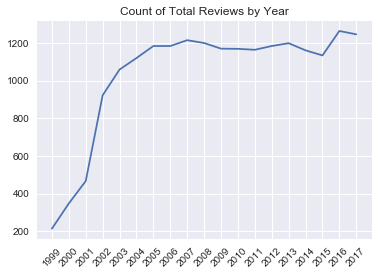

In [86]:
plt.title('Count of Total Reviews by Year')
plt.plot(df.groupby('pub_year').count()['reviewid'])
plt.xticks(range(1999,2018), rotation=45)
plt.show()

Pitchfork's "Best New Music" designation was introduced in 2003. Since 2009, Pitchfork labels between 80 and 100 albums as Best New Music.

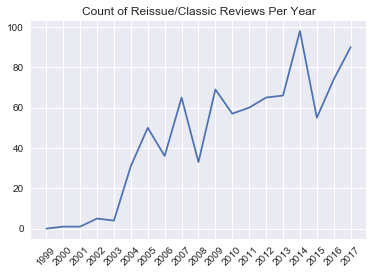

In [87]:
plt.plot(df.groupby('pub_year').sum()['reissue'])
plt.title("Count of Reissue/Classic Reviews Per Year")
plt.xticks(range(1999,2018), rotation=45)
plt.show()

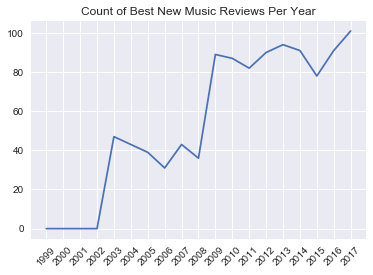

In [88]:
plt.plot(df.groupby('pub_year').sum()['best_new_music'])
plt.title("Count of Best New Music Reviews Per Year")
plt.xticks(range(1999,2018), rotation=45)
plt.show()

Best New Music albums usually receive a score of 8.3 or higher, though this is not a hard-and-fast rule.

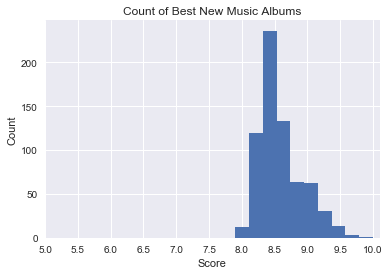

In [89]:
plt.hist(df_new[df_new['best_new_music'] == 1]['score'], bins=10)
plt.title('Count of Best New Music Albums')
plt.xticks(np.arange(5,10.5,.5))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

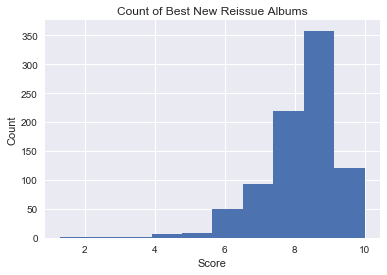

In [90]:
plt.hist(df[df['reissue'] == 1]['score'], bins=10)
plt.title('Count of Best New Reissue Albums')
# plt.xticks(np.arange(5,10.5,.5))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Distribution of Scores

The overall distribution of scores (for all albums on Pitchfork) is left skewed with a mean of 7.03. There is some expected selection bias, where Pitchfork generally reviews albums that are good enough for its readers to consume. Reviews with very low scores are either released by notable artists, or are written for entertainment value.

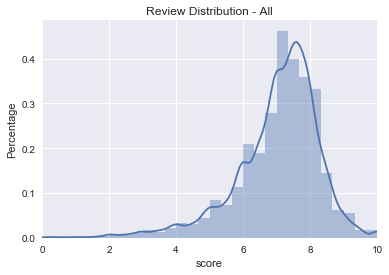

In [134]:
sns.distplot(df['score'], bins=30)
plt.title("Review Distribution - All")
plt.ylabel('Percentage')
plt.xlim(0,10)

plt.show()

print "Overall Mean:", df['score'].mean()

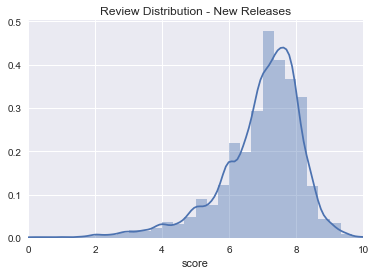

In [133]:
plt.title("Review Distribution - New Releases")
sns.distplot(df_new['score'], bins=30)
plt.xlim(0,10)

plt.show()

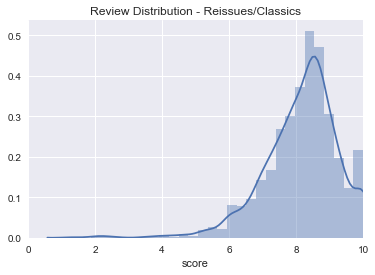

In [132]:
plt.title("Review Distribution - Reissues/Classics")
sns.distplot(df_reissue['score'], bins=30)
plt.xlim(0,10)
plt.show()

The yearly mean score hasn't changed much since 1999.

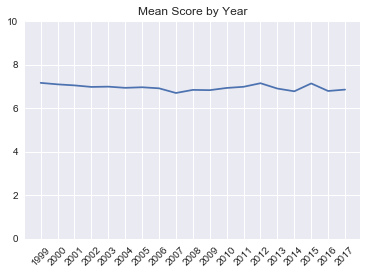

In [135]:
plt.plot(df_new['pub_year'].unique(), df_new.groupby('pub_year')['score'].mean())
plt.title('Mean Score by Year')
plt.ylim(0,10)
plt.xticks(range(1999, 2018), rotation=45)
plt.show()

## The distribution of scores given has shrunk over the past several years 

In [143]:
years = np.arange(1999, 2018)
less3 = list(df_new[df_new['score'] <= 3].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
less6 = list(df_new[df_new['score'] <= 6].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
more9 = list(df_new[df_new['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
reis_more9 = list(df_reissue[df_reissue['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_reissue.groupby('pub_year')['reviewid'].count().astype(float)))

Pitchfork has sharply decreased its frequency of giving scathing reviews

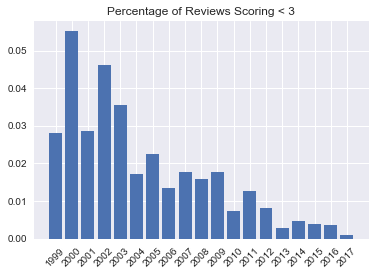

In [144]:
plt.bar(years, less3)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 3")
plt.show()

It's becoming more rare to see albums scoring below a 6. Nearly 90% of reviews in 2017 were 6+.

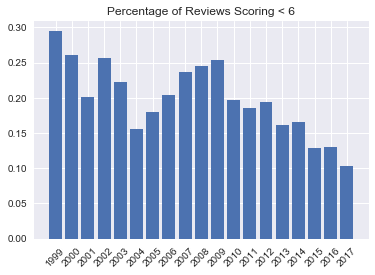

In [145]:
plt.bar(years, less6)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 6")

plt.show()

In [ ]:
# 2d distribution of scores by year (heat map)
# show 

Albums scoring above 9 are still a rare commodity

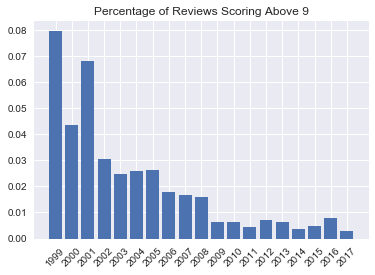

In [105]:
plt.bar(years, more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring Above 9")

plt.show()

...Except in the case of classic albums and reissues.

In [106]:
years[1:19]

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017])

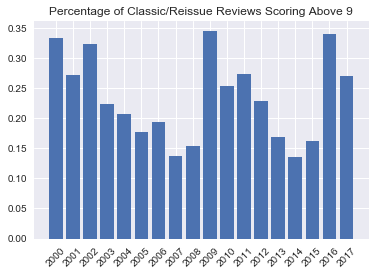

In [107]:
plt.bar(years[1:19], reis_more9)
plt.xticks(years[1:19], range(2000, 2018),rotation =45)
plt.title("Percentage of Classic/Reissue Reviews Scoring Above 9")

plt.show()

The lower boundary of the range for reviews is rising. There hasn't been an album with a score lower than 2 since 2013.

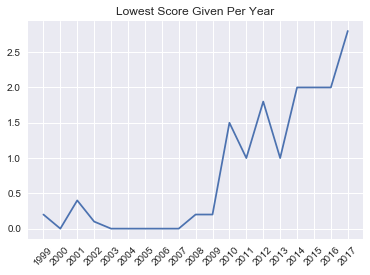

In [108]:
plt.plot(df.groupby('pub_year')['score'].min())
plt.xticks(np.arange(1999,2018), rotation=45)
plt.yticks(np.arange(0,3,.5), np.arange(0,3,.5))
plt.title("Lowest Score Given Per Year")
plt.show()

The distribution of reviews is getting narrower year over year.

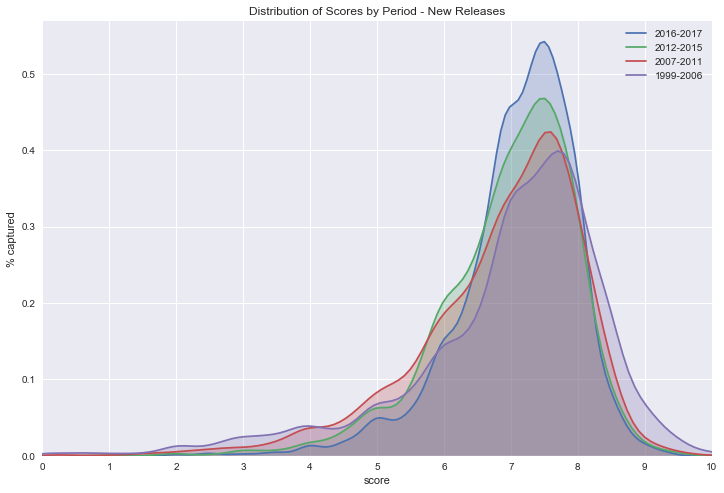

In [137]:

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Distribution of Scores by Period - New Releases')
sns.kdeplot(df_new[(df_new['pub_year'] > 2014) & (df_new['pub_year'] < 2018)]['score'], shade=True, label='2016-2017')
sns.kdeplot(df_new[(df_new['pub_year'] > 2011) & (df_new['pub_year'] < 2015)]['score'], shade=True, label='2012-2015')
sns.kdeplot(df_new[(df_new['pub_year'] > 2007) & (df_new['pub_year'] < 2012)]['score'], shade=True, label='2007-2011')
sns.kdeplot(df_new[df_new['pub_year'] < 2007]['score'], shade=True, label='1999-2006')
plt.xlabel('score')
plt.xticks(range(0,11))
plt.xlim(0,10)
plt.ylabel('% captured')
plt.legend()
plt.show()

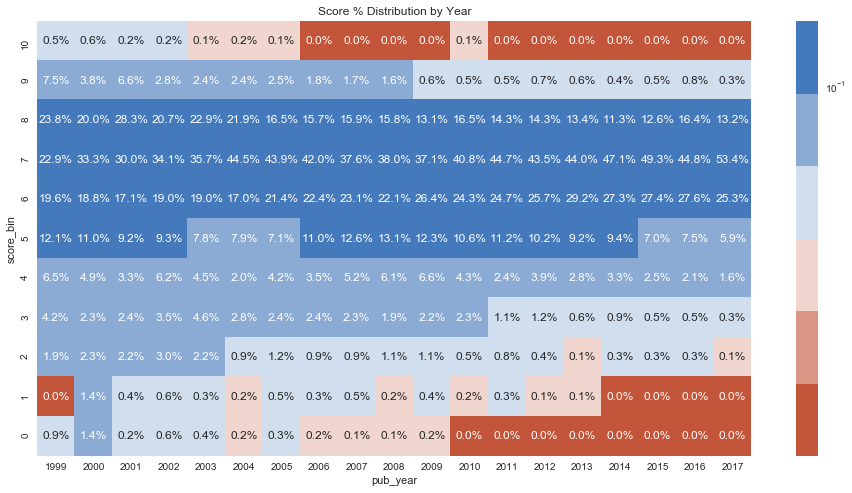

In [146]:
df_norm_col=(heatmap_df)/heatmap_df.sum()
temp_df = pd.DataFrame(df_new.groupby(['pub_year', 'score_bin'])['reviewid'].count()).reset_index()
heatmap_df = temp_df.pivot(index='score_bin', columns='pub_year', values='reviewid').fillna(0.01)

plt.figure(figsize=(16,8))
plt.title("Score % Distribution by Year")
plt.xlabel('Year')
plt.ylabel('Score')
sns.heatmap(df_norm_col[::-1], annot=(df_norm_col[::-1]).round(3), norm=LogNorm(vmin=0, vmax=1), 
            fmt='.1%', 
            cmap=sns.diverging_palette(20, 250, n=6))
plt.show()

In [148]:
# df_norm_col=(heatmap_df)/heatmap_df.sum()
# temp_df = pd.DataFrame(df_new.groupby(['pub_year', 'score_bin'])['reviewid'].count()).reset_index()
# heatmap_df = temp_df.pivot(index='score_bin', columns='pub_year', values='reviewid').fillna(0.01)

# plt.figure(figsize=(16,8))
# sns.heatmap(heatmap_df[::-1], annot=heatmap_df[::-1].round(1), norm=LogNorm(vmin=0, vmax=400), fmt='g', cmap=sns.diverging_palette(20, 250, n=6))

# plt.show()

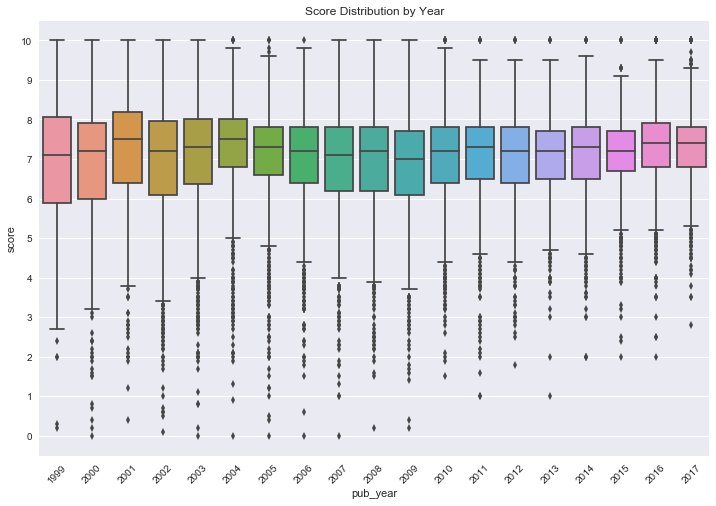

In [149]:
plt.figure(figsize=(12,8))
sns.boxplot(x=df['pub_year'], y=df['score'], data=df[['score', 'pub_year']])
plt.title('Score Distribution by Year')

plt.yticks(np.arange(0,11))
plt.xticks(rotation=45)
plt.show()

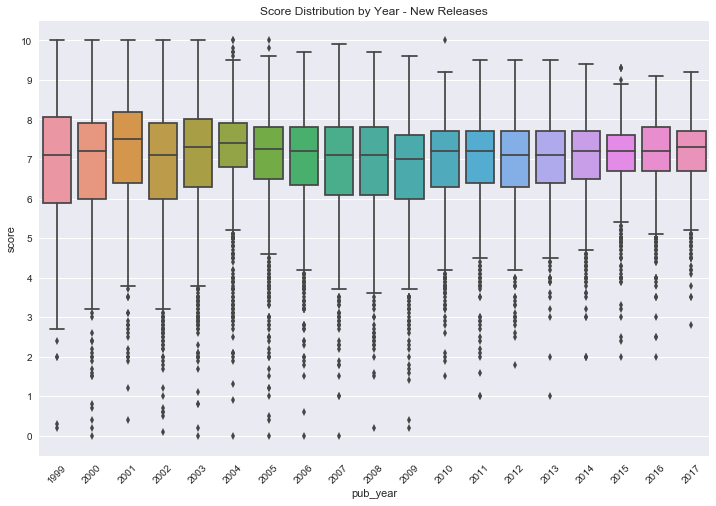

In [110]:
plt.figure(figsize=(12,8))

sns.boxplot(x=df_new['pub_year'], y=df_new['score'], data=df_new[['score', 'pub_year']])
plt.title('Score Distribution by Year - New Releases')
plt.yticks(np.arange(0,11))

plt.xticks(rotation=45)
plt.show()

In [150]:
# plt.figure(figsize=(12,8))

# sns.boxplot(x=df_reissue['pub_year'], y=df_reissue['score'], data=df_reissue[['score', 'pub_year']])
# plt.title("Score Distribution by Year -- Reissues and Classic Albums")
# plt.xticks(rotation=45)
# plt.yticks(np.arange(0,11))

# plt.show()

In [142]:
# score_by_year = df_new.groupby('pub_year').agg(['mean', 'max','min','count','sum']).reset_index()

# score_by_year['percent_bnm'] = score_by_year['best_new_music']['sum'] / score_by_year['score']['count']

# plt.plot(score_by_year['pub_year'][4:19], score_by_year['percent_bnm'][4:19])
# plt.title('Best New Music Frequency')
# plt.xticks(score_by_year['pub_year'][4:19], rotation=45)
# plt.yticks()
# plt.xlabel('Year')
# plt.ylabel('% of Albums Named Best New Music')
# plt.show()

# Basic NLP

I'm using TextBlob to measure the polarity and subjectivity of each review. Polarity is a score between [-1, 1] measuring positivity of text, and subjectivity is a score between [0, 1] where scores closer to 1 are more subjective.

In [114]:
df.groupby('pub_year')['cont_subjectivity'].mean()

pub_year
1999    0.494045
2000    0.493969
2001    0.489945
2002    0.488829
2003    0.490683
2004    0.487339
2005    0.481073
2006    0.479961
2007    0.476372
2008    0.476322
2009    0.478306
2010    0.478388
2011    0.473643
2012    0.474274
2013    0.471307
2014    0.469055
2015    0.468623
2016    0.466813
2017    0.466455
Name: cont_subjectivity, dtype: float64

Average subjectivity of reviews has gone down year over year. Authors are becoming more objective, using language that is less opinion-based.

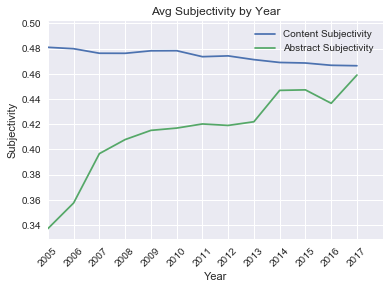

In [115]:
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['cont_subjectivity'].mean(), label='Content Subjectivity')
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['abs_subjectivity'].mean(), label='Abstract Subjectivity')

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('Avg Subjectivity by Year')
plt.legend()
plt.show()

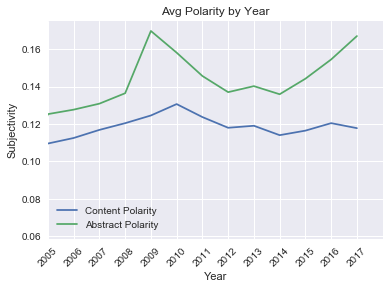

In [116]:
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['cont_polarity'].mean(), label='Content Polarity')
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['abs_polarity'].mean(), label='Abstract Polarity')

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('Avg Polarity by Year')
plt.legend()
plt.show()

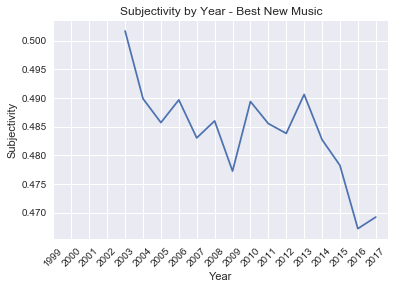

In [119]:
df_bnm = df_new[df_new['best_new_music'] == 1]
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['cont_subjectivity'].mean())
plt.xticks(years, rotation=45)
plt.title('Subjectivity by Year - Best New Music')
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.show()

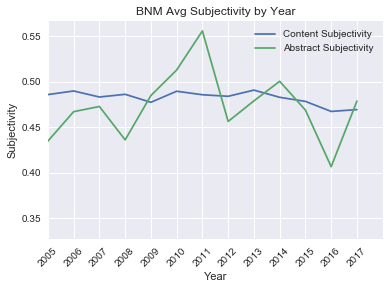

In [120]:
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['cont_subjectivity'].mean(), label='Content Subjectivity')
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['abs_subjectivity'].mean(), label='Abstract Subjectivity')

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('BNM Avg Subjectivity by Year')
plt.legend()
plt.show()

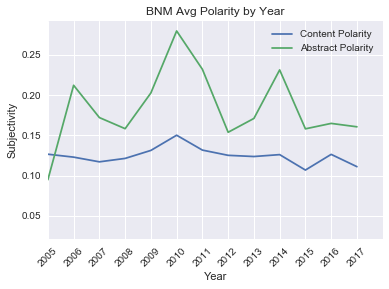

In [121]:
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['cont_polarity'].mean(), label='Content Polarity')
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['abs_polarity'].mean(), label='Abstract Polarity')

plt.xticks(years, rotation=45)
plt.xlim(2005, 2018)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('BNM Avg Polarity by Year')
plt.legend()
plt.show()

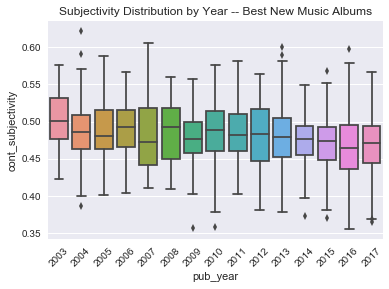

In [124]:
sns.boxplot(x=df[df['best_new_music'] == 1]['pub_year'], y=df[df['best_new_music'] == 1]['cont_subjectivity'], data=df[df['best_new_music'] == 1][['score', 'cont_subjectivity']])
# plt.ylim(.28, .7)
plt.title("Subjectivity Distribution by Year -- Best New Music Albums")
plt.xticks(rotation=45)
# plt.yticks(np.arange(.3,.7,.025))

plt.show()

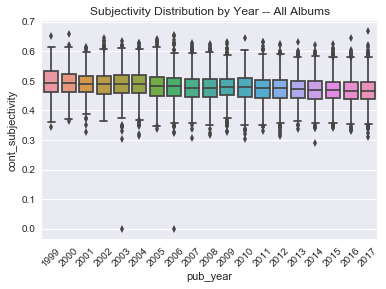

In [127]:
sns.boxplot(x=df['pub_year'], y=df['cont_subjectivity'], data=df[['score', 'cont_subjectivity']])
# plt.ylim(.28, .7)
plt.title("Subjectivity Distribution by Year -- All Albums")
# plt.yticks(np.arange(.3,.7,.025))

plt.xticks(rotation=45)
plt.show()

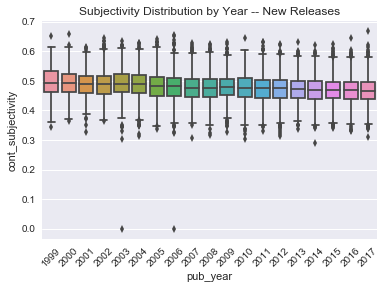

In [129]:
sns.boxplot(x=df_new['pub_year'], y=df_new['cont_subjectivity'], data=df_new[['score', 'cont_subjectivity']])
plt.title("Subjectivity Distribution by Year -- New Releases")
# plt.ylim(.28, .7)
plt.xticks(rotation=45)
# plt.yticks(np.arange(.3,.7,.025))

plt.show()

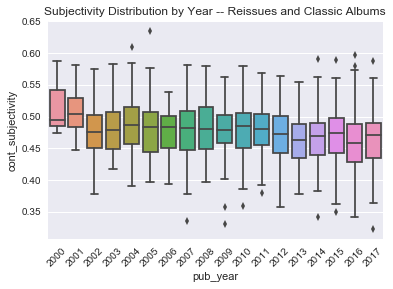

In [130]:
sns.boxplot(x=df_reissue['pub_year'], y=df_reissue['cont_subjectivity'], data=df_reissue[['score', 'cont_subjectivity']])
plt.title("Subjectivity Distribution by Year -- Reissues and Classic Albums")
plt.xticks(rotation=45)
# plt.yticks(np.arange(.3,.7,.025))

plt.show()

## Simple Linear Regression Using Subjectivity/Polarity

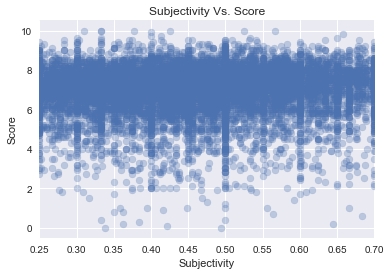

In [131]:
plt.scatter(df_new['abs_subjectivity'], df_new['score'], alpha=.3)
plt.title('Subjectivity Vs. Score')
plt.ylabel("Score")
plt.xlim(.25, .7)
plt.xlabel("Subjectivity")
plt.show()

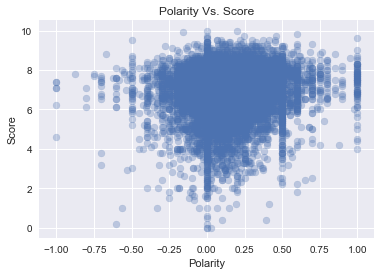

In [132]:
plt.scatter(df_new[df_new['pub_year'] > 2004]['abs_polarity'], df_new[df_new['pub_year'] > 2004]['score'], alpha=.3)
plt.title('Polarity Vs. Score')
plt.ylabel("Score")
plt.xlabel("Polarity")
plt.show()

In [133]:
import statsmodels.api as sm

In [134]:
Y = df['score']
X = df[['abs_polarity', 'cont_polarity', 'abs_subjectivity', 'cont_subjectivity', 'pub_year', 'new_album', 'genre_rock']]
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     278.3
Date:                Wed, 10 Jan 2018   Prob (F-statistic):               0.00
Time:                        09:02:52   Log-Likelihood:                -31701.
No. Observations:               19620   AIC:                         6.342e+04
Df Residuals:                   19612   BIC:                         6.348e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7474      3.746      0.200      0.842      -6.595       8.090
abs_polarity          0.0831      0.044      1.872      0.061      -0.004       0.170
cont_polarity         3.7056      0.166     22.323      0.000       3.380       4.031
abs_subjectivity      0.2191      0.039      5.572      0.000       0.142       0.296
cont_subjectivity    -0.9510      0.195     -4.865      0.000      -1.334      -0.568
pub_year              0.0037      0.002      1.977      0.048    3.11e-05       0.007
new_album            -1.1739      0.035    -33.643      0.000      -1.242      -1.106
genre_rock           -0.1383      0.018     -7.819      0.000      -0.173      -0.104
==============================================================================
Omnibus:                     4258.452   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10397.909
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                       5.632   Cond. No.                     8.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
def plot_subj_violins_score(df, genre='all genres'):
    scores = list(df.score_bin.unique())
    pol_dist = {1: [],}
    for pol,score in zip(df.subjectivity.astype(list), df.score_bin.astype(list)):
        if score not in pol_dist.keys():
            pol_dist[score] = []
        else:
            pol_dist[score] = pol_dist[score] + [pol]

    plt.figure(figsize=(30,14))
#     plt.hlines(df['subjectivity'].mean(), 0, 10, linestyles='dotted')
    for each in scores:
        plt.xticks(range(0,11), fontsize=16)
        plt.violinplot(np.array(pol_dist[each]), [each], widths=1,showmedians=True,showextrema=True)
    plt.title('Subjectivity Distribution by Score ({})'.format(genre), fontsize=24)
    plt.ylabel('Subjectivity', fontsize=16)
    plt.xlabel('Binned Score', fontsize=16)